### Pretrained ConvNet:
#### Feature extraction

In [2]:
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [3]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### At this point, there are two ways you could proceed:
- Running the convolutional base over your dataset, recording its output to a Numpy array on disk, and then using this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. But for the same reason, this technique won’t allow you to use data augmentation.
- Extending the model you have (conv_base) by adding Dense layers on top, and running the whole thing end to end on the input data. This will allow you to use data augmentation, because every input image goes through the convolutional base every time it’s seen by the model. But for the same reason, this technique is far more expensive than the first.

### Fast feature extraction using the pretrained convolutional base without data augmentation

In [6]:
base_dir = '/home/nbuser/courses/fastai/courses/dl1/data/dogscats/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150),
                                            batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Dfining and training the densely connected classifier

In [7]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 11s 5ms/step - loss: 0.5948 - acc: 0.6870 - val_loss: 0.4347 - val_acc: 0.8400
Epoch 2/30
2000/2000 [==============================] - 1s 331us/step - loss: 0.4205 - acc: 0.8120 - val_loss: 0.3574 - val_acc: 0.8750
Epoch 3/30
2000/2000 [==============================] - 1s 352us/step - loss: 0.3498 - acc: 0.8540 - val_loss: 0.3185 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 1s 327us/step - loss: 0.3105 - acc: 0.8745 - val_loss: 0.2967 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 335us/step - loss: 0.2831 - acc: 0.8800 - val_loss: 0.2818 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 1s 337us/step - loss: 0.2616 - acc: 0.8965 - val_loss: 0.2706 - val_acc: 0.8960
Epoch 7/30
2000/2000 [==============================] - 1s 347us/step - loss: 0.2412 - acc: 0.9020 - val_loss: 0.2734 - val_acc: 0.8880
E

#### Plotting the results

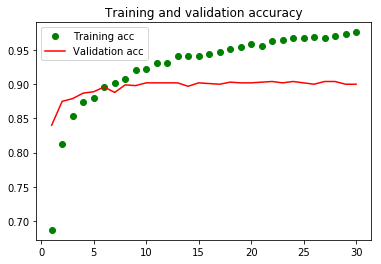

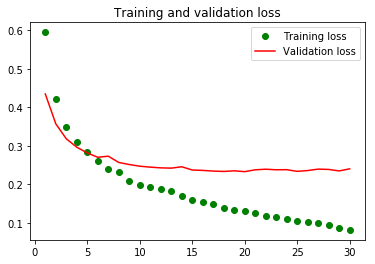

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

- Note: We reach a validation accuracy of about 90% — much better than we achieved in the previous section with the small model trained from scratch. But the plots also indicate that we’re overfitting almost from the start—despite using dropout with a fairly large rate. That’s because this technique doesn’t use data augmentation, which is essential for preventing overfitting with small image datasets.
### Feature extraction with data augmentation

In [12]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


- Note: Before compile and train the model, it’s very important to freeze the convolutional base. Freezing a layer or set of layers means preventing their weights from being updated during training. If we don’t do this, then the representations that were previously learned by the convolutional base will be modified during training. Because the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In [14]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


#### Training the model end to end with a frozen convolutional base

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), 
                                                    batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                        batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30,
                              validation_data=validation_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 53s 534ms/step - loss: 0.6053 - acc: 0.6835 - val_loss: 0.4713 - val_acc: 0.8000
Epoch 2/30
100/100 [==============================] - 49s 490ms/step - loss: 0.4800 - acc: 0.7930 - val_loss: 0.3709 - val_acc: 0.8640
Epoch 3/30
100/100 [==============================] - 55s 552ms/step - loss: 0.4347 - acc: 0.8045 - val_loss: 0.3337 - val_acc: 0.8680
Epoch 4/30
100/100 [==============================] - 52s 517ms/step - loss: 0.3952 - acc: 0.8410 - val_loss: 0.3043 - val_acc: 0.8880
Epoch 5/30
100/100 [==============================] - 48s 480ms/step - loss: 0.3838 - acc: 0.8335 - val_loss: 0.2900 - val_acc: 0.8940
Epoch 6/30
100/100 [==============================] - 46s 457ms/step - loss: 0.3683 - acc: 0.8380 - val_loss: 0.2783 - val_acc: 0.8980
Epoch 7/30
100/100 [==============================] - 46s 458ms/step - loss: 0.3587 - acc: 0.8405 - val_lo

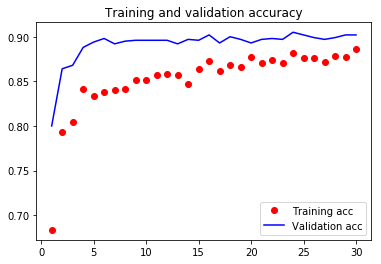

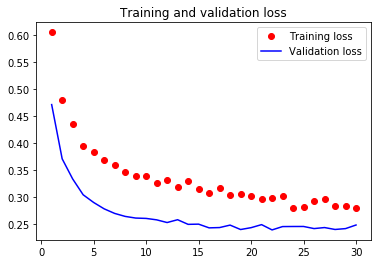

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Fine-Tuning
- Fine-tuning consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in this case, the fully connected classifier) and these top layers. This is called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the current problem.
Thus the
#### Steps for fine-tuning a network are as follow:
 - Add the custom network on top of an already-trained base network.
 - Freeze the base network.
 - Train the newely added part.
 - Unfreeze some layers in the base network.
 - Jointly train both these layers and the part you added.

In [18]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

#### Fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.
#### Why not fine-tune more layers? Why not fine-tune the entire convolutional base?
- Earlier layers in the convolutional base encode more-generic, reusable features, whereas layers higher up encode more-specialized features. It’s more useful to fine-tune the more specialized features, because these are the ones that need to be repurposed for the new problem. There would be fast-decreasing returns in fine-tuning lower layers.
- The more parameters we’re training, more risk of overfitting. The convolutional base has 15 million parameters, so it would be risky to attempt to train it on your small dataset. It’s a good strategy to fine-tune only the top two or three layers in the convolutional base.

In [19]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=5,
                              validation_data=validation_generator, validation_steps=50)

Epoch 1/5
100/100 [==============================] - 54s 542ms/step - loss: 0.0229 - acc: 0.9915 - val_loss: 0.2549 - val_acc: 0.9410
Epoch 2/5
100/100 [==============================] - 53s 534ms/step - loss: 0.0196 - acc: 0.9945 - val_loss: 0.3971 - val_acc: 0.9240
Epoch 3/5
100/100 [==============================] - 54s 542ms/step - loss: 0.0254 - acc: 0.9925 - val_loss: 0.2941 - val_acc: 0.9280
Epoch 4/5
100/100 [==============================] - 57s 568ms/step - loss: 0.0152 - acc: 0.9960 - val_loss: 0.3528 - val_acc: 0.9260
Epoch 5/5
100/100 [==============================] - 55s 551ms/step - loss: 0.0194 - acc: 0.9930 - val_loss: 0.2684 - val_acc: 0.9400


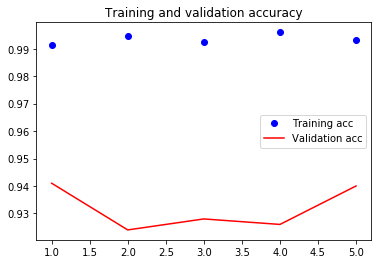

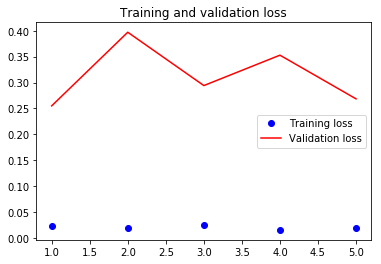

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Note:- These curves look noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving averages of these quantities. 
### Smoothing the plot

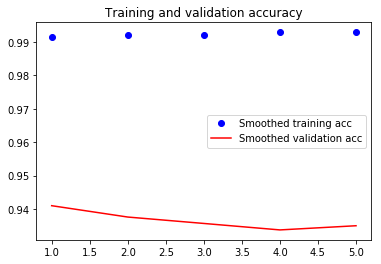

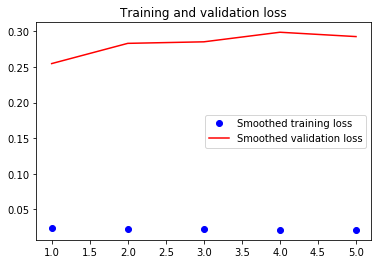

In [26]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'r', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'r', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Evaluate the model on the test data:

In [27]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9409999942779541


In [28]:
model.save('cats_and_dogs_small_Vgg16.h5')